# Calculate POP2 heat budget using xgcm

In this notebook, we are going to use xgcm with metrics to demonstrate budget closure. This notebook was contributed by [Anna-Lena Deppenmeier](https://github.com/ALDepp).


This is an image of the POP output structure on the horizontal B-grid courtesy of [Yassir Eddebbar](https://github.com/Eddebbar).

<img src="POP_Grid.png" alt="Drawing" style="width: 800px;"/>

## Import packages and define functions

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm

import pop_tools


def pop_find_lat_ind(loc, LATDAT):
    return np.abs(LATDAT[:, 0].values - loc).argmin()


def pop_find_lon_ind(loc, LONDAT, direction="w"):
    if direction.lower() in ["east", "e"]:
        value = loc
    elif direction.lower() in ["west", "w"]:
        value = 360 - loc
    else:
        print("I do not know which direction.")
    return np.nanargmin(np.abs(LONDAT[152, :].values - value))

## Load Dataset

In [2]:
fdir = '/glade/scratch/whokim/archive/g210.G_JRA.v14.gx1v7.01_TB/ocn/hist/'
ds = xr.open_dataset(fdir + 'g210.G_JRA.v14.gx1v7.01_TB.pop.h.0270-02.nc')
# ds = ds.isel(time=0)
# ds

In [3]:
# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = [-8, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 8]
for j in inds_lat:
    if j < 0:
        lola_inds["j_" + str(j)[1:] + "s"] = pop_find_lat_ind(j, ds.TLAT)
    else:
        lola_inds["j_" + str(j) + "n"] = pop_find_lat_ind(j, ds.TLAT)

inds_lon = range(95, 185, 5)
for i in inds_lon:
    lola_inds["i_" + str(i) + "_w"] = pop_find_lon_ind(i, ds.TLONG)

In [ ]:
# just making sure everything works
# ds.TEMP.isel(z_t=0).mean(dim="time").plot(levels=np.arange(20, 30.5, 0.5), cmap="RdYlBu_r")
ds.TEMP.isel(z_t=0).plot(levels=np.arange(20, 30.5, 0.5), cmap="RdYlBu_r")
# plt.scatter(lola_inds["i_140_w"], lola_inds["j_0n"], marker="*");

## Set up vertical thickness and volume for scaling

In [4]:
ds["DZT"] = xr.DataArray(ds.dz.values[:,None,None]*np.ones((len(ds.dz),len(ds.nlat),len(ds.nlon)))
                , dims=['z_t','nlat','nlon'], coords={'z_t':ds.z_t,'nlat':ds.nlat,'nlon':ds.nlon})
ds["DZU"] = xr.DataArray(ds.dz.values[:,None,None]*np.ones((len(ds.dz),len(ds.nlat),len(ds.nlon)))
                , dims=['z_t','nlat','nlon'], coords={'z_t':ds.z_t,'nlat':ds.nlat,'nlon':ds.nlon})

ds.DZT.attrs["long_name"] = "Thickness of T cells"
ds.DZT.attrs["units"] = "centimeter"
ds.DZT.attrs["grid_loc"] = "3111"
ds.DZU.attrs["long_name"] = "Thickness of U cells"
ds.DZU.attrs["units"] = "centimeter"
ds.DZU.attrs["grid_loc"] = "3221"

# make sure we have the cell volumne for calculations
VOL = (ds.dz * ds.DXT * ds.DYT).compute()
KMT = ds.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds["VOL"] = VOL

ds.VOL.attrs["long_name"] = "volume of T cells"
ds.VOL.attrs["units"] = "centimeter^3"

ds.VOL.attrs["grid_loc"] = "3111"

100%|██████████| 384/384 [00:00<00:00, 921.97it/s]


## Set up dataset to gather budget terms

In [5]:
budget = xr.Dataset()

### Set grid and data set for xgcm with metrics

In [6]:
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

# here we get the xgcm compatible dataset
gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)

for coord in ["nlat", "nlon"]:
    if coord in dsxgcm.coords:
        dsxgcm = dsxgcm.drop_vars(coord)

### 0) Tendency

In [7]:
budget['TEND_TEMP'] = dsxgcm.TEND_TEMP

### i) Total heat advection

In [8]:
budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
budget["WTT"] = (
    gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL
)
budget["TOT_ADV"] = budget["UET"] + budget["VNT"] + budget["WTT"]

### ii) Total heat divergence due to parameterizations

In [18]:
tmp=(dsxgcm.UISOP + dsxgcm.USUBM)*(dsxgcm.dz*dsxgcm.DYT).values/dsxgcm.VOL.values \
    *gridxgcm.interp(dsxgcm.TEMP, 'X')
budget["UET_PARAM"] = -(gridxgcm.diff(tmp * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)

tmp=(dsxgcm.VISOP + dsxgcm.VSUBM)*(dsxgcm.dz*dsxgcm.DXT).values/dsxgcm.VOL.values \
    *gridxgcm.interp(dsxgcm.TEMP, 'Y')
budget["VNT_PARAM"] = -(gridxgcm.diff(tmp * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)

tmp=(dsxgcm.WISOP + dsxgcm.WSUBM)*dsxgcm.DXT*dsxgcm.DYT/dsxgcm.VOL.values \
    *gridxgcm.interp(dsxgcm.TEMP, 'Z')
budget["WTT_PARAM"] = (gridxgcm.diff(tmp.fillna(0)*(dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values
                               , axis="Z")/dsxgcm.VOL)

budget["TOT_PARAM"] = budget.UET_PARAM + budget.VNT_PARAM + budget.WTT_PARAM 

### iii) Heat flux due to vertical mixing:
#### includes surface flux at the 0th layer

In [9]:
budget["DIA_IMPVF_TEMP"] = -(
    gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL)

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsxgcm.SHF - dsxgcm.SHF_QSW) * dsxgcm.hflux_factor

budget["DIA_IMPVF_TEMP"][:,0, :, :] = (
    SRF_TEMP_FLUX * dsxgcm.TAREA - dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["KPP_SRC_TMP"] = dsxgcm.KPP_SRC_TEMP
budget["VDIF"] = budget["DIA_IMPVF_TEMP"] + budget["KPP_SRC_TMP"]

### iv) Heat flux due to horizontal diffusion

In [10]:
budget["HDIFE_TEMP"] = gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL
budget["HDIFN_TEMP"] = gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL
budget["HDIF"] = budget["HDIFE_TEMP"] + budget["HDIFN_TEMP"]

### v) Solar Penetration

In [11]:
budget["QSW_3D"] = -gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z") / dsxgcm.DZT

### plot to make sure it closes at (0N, 140W)

In [12]:
subset = budget.isel(nlon_t=lola_inds["i_140_w"], nlat_t=lola_inds["j_0n"], time=0)
# subset = budget.isel(nlon_t=lola_inds["i_180_w"], nlat_t=lola_inds["j_40n"])

CPU times: user 64.1 ms, sys: 6.42 ms, total: 70.5 ms
Wall time: 110 ms


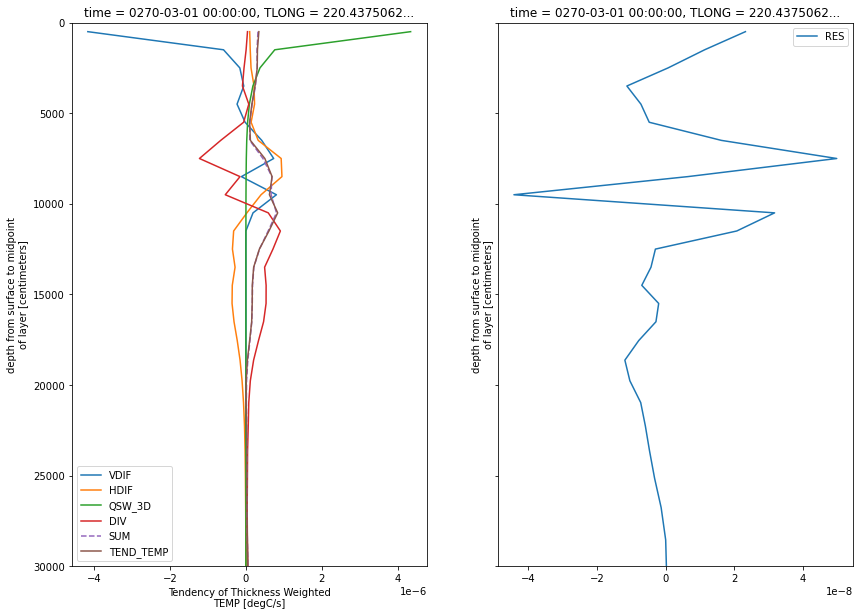

In [15]:
%%time

fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

# plot individual components
subset.VDIF.plot(y="z_t", ylim=(500e2, 0), label="VDIF", ax=ax[0])
subset.HDIF.plot(y="z_t", ylim=(500e2, 0), label="HDIF", ax=ax[0])
subset.QSW_3D.plot(y="z_t", ylim=(500e2, 0), label="QSW_3D", ax=ax[0])
subset.TOT_ADV.plot(y="z_t", ylim=(500e2, 0), label="DIV", ax=ax[0])
# subset.TOT_PARAM.plot(y="z_t", ylim=(500e2, 0), label="DIV_PARAM", ax=ax[0])

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV).plot(
    y="z_t", ylim=(500e2, 0), label="SUM", ls="--", ax=ax[0])

# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(500e2, 0), label="TEND_TEMP", ax=ax[0])

ax[0].legend()

(subset.TEND_TEMP - (subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV)).plot(
    y="z_t", ylim=(300e2, 0), label="RES", ax=ax[1])

# plot sum
# (subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV).plot(
#     y="z_t", ylim=(500e2, 0), xlim=(-1.6e-6, 1.1e-6), label="SUM", ls="--", ax=ax[1])

# plot tendency
# subset.TEND_TEMP.plot(y="z_t", ylim=(500e2, 0), xlim=(-1.6e-6, 1.1e-6), label="TEND_TEMP", ax=ax[1])

ax[1].legend();

In [ ]:
# You may need to install watermark (conda install -c conda-forge watermark)
import xgcm  # just to display the version

%load_ext watermark
%watermark -d -iv -m -g
print("Above are the versions of the packages this works with.")